## Downloads

In [ ]:
!pip install ydata-profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.5 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=50abb7e5a93beb2fedf1c0d6a85d68a968975dd5d8a1ebd7727be645e5d7f7c2
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


## Imports

In [ ]:
import pandas as pd
from ydata_profiling import ProfileReport
from google.colab import output
import webbrowser
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np

## Initial Analysis

In [ ]:
df_raw = pd.read_csv('data.csv', na_values='?')

profile = ProfileReport(df_raw, minimal=True,       # Desativa cálculos pesados
                            explorative=False,  # Remove análises complexas
                            correlations=None,
                            title="Series Temporais Tráfego")


# profile.to_file("basic_report.html")

In [ ]:
with open('report.html', 'r') as f:
    html_string = f.read()

HTML(html_string)

Observa-se, a partir do relatório gerado, que não há valores faltantes no dataset obtido. Por outro lado, há uma grande porcentagem dos dados com o valor 0 (zero).
A existência de zeros parece razoável, mas deve-se garantir que de fato é um valor válido, e não apenas uma maneira de enumerar dados faltantes.

## Separating Timestamp
A existência de uma coluna unificada de timestamp é algo negativo, pois dessa forma cada horário é único por estar em dias diferentes, o que atrapalha na hora de definir relações entre horários e tráfego.
Por isso, irei transformar a coluna timestamp em 3 novas colunas --> dia | hora | minuto.

Assim nosso foco estará na relação entre hora e tráfego, pois assim evitaremos problemas de não relacionarmos altas em, por exemplo, 7:15, com altas em 7:20.

In [ ]:
df = df_raw.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%m/%d/%Y %H:%M')

df['dia'] = df['timestamp'].dt.day
df['mes'] = df['timestamp'].dt.month
df['ano'] = df['timestamp'].dt.year
df['hora'] = df['timestamp'].dt.hour
df['minuto'] = df['timestamp'].dt.minute

df = df.drop('timestamp', axis=1)

In [ ]:
# Generate the report
profile = ProfileReport(df,
    minimal=False,
    explorative=True,
    title="Séries Temporais - Tráfego",
    correlations={
        "pearson": {"calculate": True},  # Correlação linear
        "spearman": {"calculate": False},  # Desativa rank correlation
        "kendall": {"calculate": False},   # Desativa correlação ordinal
        "phi_k": {"calculate": False}      # Desativa correlação não-linear pesada
    },
    interactions={
        "continuous": False,  # Mostra relações entre variáveis contínuas
        "targets": [],       # Não calcula relações com target específico
        "categorical": False # Desativa interações categóricas (pesadas)
    },
    missing_diagrams={
        "bar": False,         # Gráfico simples de missing
        "matrix": False,     # Desativa diagrama matricial (pesado)
        "heatmap": False     # Desativa heatmap de missing (muito pesado)
    },
    samples=None,            # Remove amostras de dados brutos
    duplicates=None,         # Desativa verificação de duplicatas
    plot={
        "histogram": {"bins": 20},       # Reduz complexidade de histogramas
        "scatter": {"samples": 500},     # Limita pontos em scatter plots
        "correlation": {"threshold": 0.7} # Mostra só correlações fortes
    }
)

# Save the report to .html
profile.to_file("report_split.html")

# with open('report_split.html', 'r') as f:
#     html_string = f.read()

## Análises Manuais
Aqui irei averiguar, na mão, algumas relações do dataset. Em quais horários ocorre um aumento, onde houveram picos.

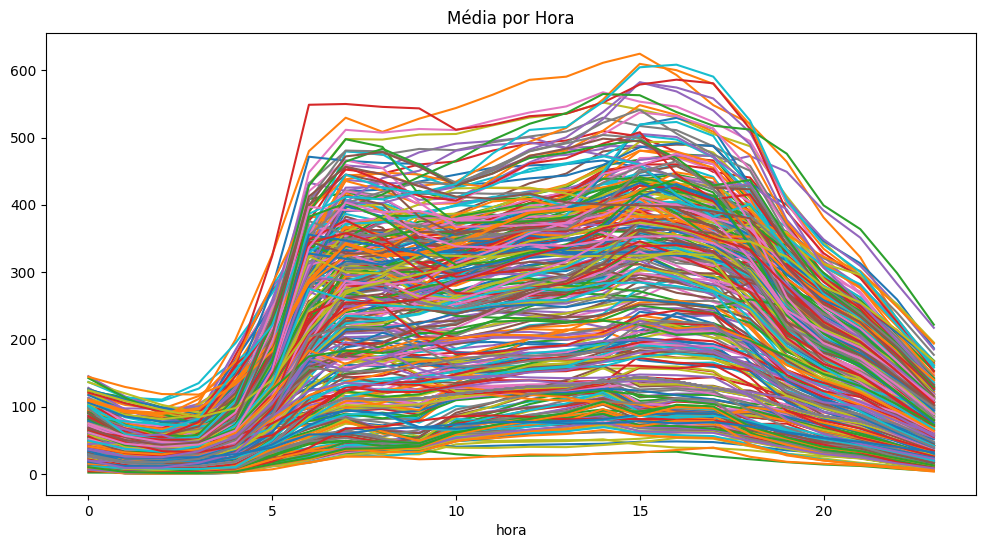

In [ ]:
colunas_analise = df.drop(columns=['dia', 'mes', 'ano', 'minuto'])
estatisticas_por_hora = colunas_analise.groupby('hora').mean()

estatisticas_por_hora.plot(kind='line', figsize=(12, 6), legend=False)
plt.title('Média por Hora')
plt.show()

## Procurando por Outliers

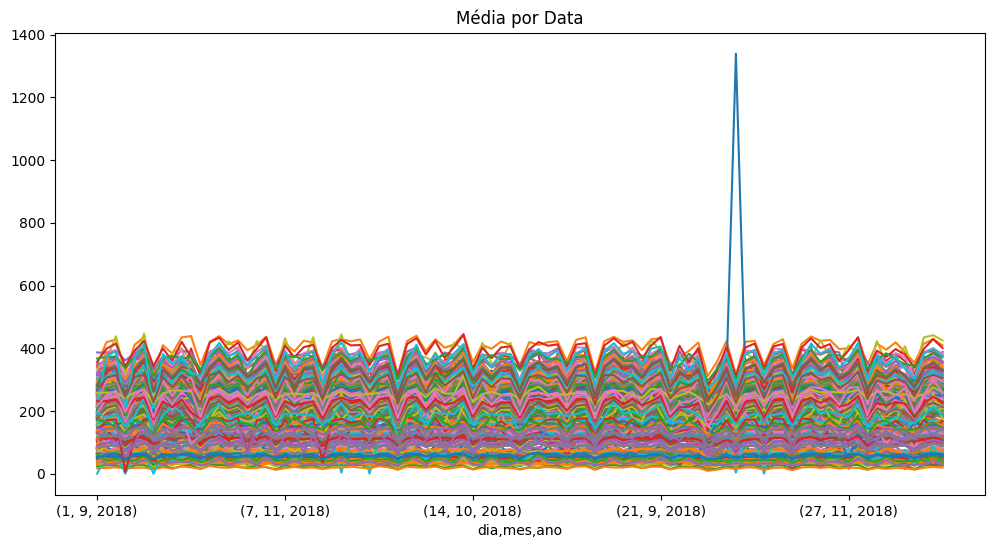

In [ ]:
df_dia = df.copy()

df_dia = df_dia.drop(['hora', 'minuto'], axis=1)

estatisticas_por_data = df_dia.groupby(['dia', 'mes', 'ano']).mean()

estatisticas_por_data.plot(kind='line', figsize=(12, 6), legend=False)
plt.title('Média por Data')
plt.show()

Aqui encontramos um grande outlier, agora basta encontramos o sensor e o dia exato do acontecimento, visto que esse outlier pode interferir de maneira errônea nos dados futuramente. Pelo que foi percebido no gráfico, esse único outlier ultrapassou 1000 em sua média, então basta encontramos:

In [ ]:
df_outliers = df.copy()

mask_outliers = (estatisticas_por_data > 1000).any(axis=1)
outliers_1000 = estatisticas_por_data[mask_outliers]

for index, row in outliers_1000.iterrows():
    dia, mes, ano = index
    sensores_problematicos = row[row > 1000].index.tolist()  # Sensores média > 1000
    valores = row[row > 1000].values

    if sensores_problematicos:
        mask = (df_outliers['dia'] == dia) & (df_outliers['mes'] == mes) & (df_outliers['ano'] == ano)
        df_outliers.loc[mask, sensores_problematicos] = np.nan

    print(f"\nData: {dia}/{mes}/{ano}")
    for sensor, valor in zip(sensores_problematicos, valores):
        print(f"  → Sensor '{sensor}': Média = {valor:.2f}")


Data: 23/11/2018
  → Sensor '312139': Média = 1339.39


**Recomendação**: imputar valores para os sensores encontrados nos dias mostrados, tanto os com média zero, quanto o com média 1339.

## Imputando novos valores para os outliers


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


meta_cols = ['dia', 'mes', 'ano', 'hora', 'minuto']


sensor_cols = [col for col in df_outliers.columns if col not in meta_cols]

imputer = IterativeImputer(random_state=0, min_value=0)

imputed_data = imputer.fit_transform(df_outliers[sensor_cols])

df_imputed_features = pd.DataFrame(imputed_data, columns=sensor_cols, index=df_outliers.index)

# Juntar as colunas de data originais com os sensores imputados
df_imputed = pd.concat([df_outliers[meta_cols], df_imputed_features], axis=1)

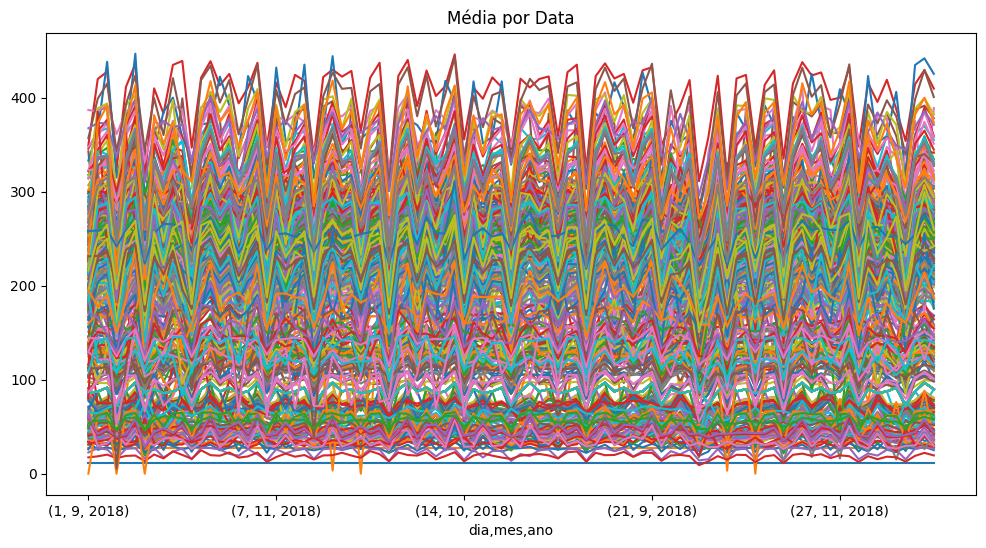

In [ ]:
# Verificando se arrumei o Outlier.
estatisticas_por_data_novo = df_imputed.groupby(['dia', 'mes', 'ano']).mean()

estatisticas_por_data_novo.plot(kind='line', figsize=(12, 6), legend=False)
plt.title('Média por Data')
plt.show()

In [ ]:
# Vendo se os outliers ainda aparecem (no gráfico parece que eles tão lá) (são o de 0, nao tiro mais eles)
mask_outliers = (estatisticas_por_data_novo == 0).any(axis=1)
outliers_0 = estatisticas_por_data_novo[mask_outliers]

for index, row in outliers_0.iterrows():
    dia, mes, ano = index
    sensores_problematicos = row[row == 0].index.tolist()
    valores = row[row == 0].values

    print(f"\nData: {dia}/{mes}/{ano}")
    for sensor, valor in zip(sensores_problematicos, valores):
        print(f"  → Sensor '{sensor}': Média = {valor:.2f}")


Data: 1/9/2018
  → Sensor '314711': Média = 0.00

Data: 2/9/2018
  → Sensor '314711': Média = 0.00

Data: 3/9/2018
  → Sensor '314711': Média = 0.00

Data: 10/11/2018
  → Sensor '318736': Média = 0.00

Data: 24/11/2018
  → Sensor '318736': Média = 0.00


In [ ]:
# Lista de todos os casos problemáticos para teste
casos_de_teste = [
    {'dia': 1, 'mes': 9, 'ano': 2018, 'sensor': '314711'},
    {'dia': 2, 'mes': 9, 'ano': 2018, 'sensor': '314711'},
    {'dia': 3, 'mes': 9, 'ano': 2018, 'sensor': '314711'},
    {'dia': 10, 'mes': 11, 'ano': 2018, 'sensor': '318736'},
    {'dia': 24, 'mes': 11, 'ano': 2018, 'sensor': '318736'},
]

for caso in casos_de_teste:
    dia_problema = caso['dia']
    mes_problema = caso['mes']
    ano_problema = caso['ano']
    sensor_problematico = caso['sensor']

    print(f"--- ANÁLISE PARA O DIA {dia_problema}/{mes_problema}/{ano_problema} | SENSOR {sensor_problematico} ---")
    try:
        indice_sensor = sensor_cols.index(sensor_problematico)
    except ValueError:
        print(f"ERRO: Sensor '{sensor_problematico}' não foi encontrado.\n\n")
        continue

    inicio = max(0, indice_sensor - 2)
    fim = min(len(sensor_cols), indice_sensor + 3)
    sensores_para_analise = sensor_cols[inicio:fim]

    if sensor_problematico not in sensores_para_analise:
        sensores_para_analise.insert(0, sensor_problematico)

    df_antes = df_outliers[
        (df_outliers['dia'] == dia_problema) &
        (df_outliers['mes'] == mes_problema) &
        (df_outliers['ano'] == ano_problema)
    ]

    df_depois = df_imputed[
        (df_imputed['dia'] == dia_problema) &
        (df_imputed['mes'] == mes_problema) &
        (df_imputed['ano'] == ano_problema)
    ]

    if df_antes.empty:
        print("Nenhum dado encontrado para esta data.\n\n")
        continue

    print("\n--- VALORES ANTES DA IMPUTAÇÃO ---\n")
    print(df_antes[sensores_para_analise].head(10))

    print("\n\n--- VALORES DEPOIS DA IMPUTAÇÃO ---\n")
    print(df_depois[sensores_para_analise].head(10))
    print("\n\n")

--- ANÁLISE PARA O DIA 1/9/2018 | SENSOR 314711 ---

--- VALORES ANTES DA IMPUTAÇÃO ---

   318800  318801  314711  314712  318815
0    46.0   181.0     0.0   182.0    46.0
1    44.0   172.0     0.0   174.0    44.0
2    46.0   195.0     0.0   183.0    46.0
3    44.0   153.0     0.0   126.0     2.0
4    40.0   132.0     0.0   117.0     3.0
5    36.0   134.0     0.0   120.0     2.0
6    36.0   117.0     0.0   127.0     1.0
7    36.0   117.0     0.0   114.0     5.0
8    34.0   122.0     0.0   123.0     4.0
9    32.0   130.0     0.0   126.0     4.0


--- VALORES DEPOIS DA IMPUTAÇÃO ---

   318800  318801  314711  314712  318815
0    46.0   181.0     0.0   182.0    46.0
1    44.0   172.0     0.0   174.0    44.0
2    46.0   195.0     0.0   183.0    46.0
3    44.0   153.0     0.0   126.0     2.0
4    40.0   132.0     0.0   117.0     3.0
5    36.0   134.0     0.0   120.0     2.0
6    36.0   117.0     0.0   127.0     1.0
7    36.0   117.0     0.0   114.0     5.0
8    34.0   122.0     0.0   123.

In [ ]:
# Obter novo csv

df_imputed['timestamp'] = pd.to_datetime({
    'year': df_imputed['ano'],
    'month': df_imputed['mes'],
    'day': df_imputed['dia'],
    'hour': df_imputed['hora'],
    'minute': df_imputed['minuto']
})

df_imputed = df_imputed.drop(['dia', 'mes', 'ano', 'hora', 'minuto'], axis=1)
df_imputed['timestamp'] = df_imputed['timestamp'].dt.strftime('%m/%d/%Y %H:%M')
colunas = ['timestamp'] + [col for col in df_imputed.columns if col != 'timestamp']
df_imputed = df_imputed[colunas]

df_imputed.to_csv('dados_imputados.csv', index=False)

KeyError: 'ano'

In [ ]:
df_imputed['timestamp'] = pd.to_datetime(df_imputed['timestamp'], format='mixed', dayfirst=True)


# Formata para 'dd/mm/yyyy H:MM' (sem zero à esquerda na hora)
df_imputed['timestamp'] = df_imputed['timestamp'].dt.strftime('%d/%m/%Y %-H:%M')

# Salva se quiser
df_imputed.to_csv('dados_imputados.csv', index=False)

## Procurando Falhas em Sensores

Outros outliers por falha de sensores podem ser obtidos ao observar duas situações:

1. alguma mudança abrupta de um sensor indo pra zero sem uma diminuição gradual.
2. algum dia em que haja predominância de zeros em um sensor

In [ ]:
colunas_analise = df.drop(columns=['minuto'])
estatisticas_por_hora_dia = colunas_analise.groupby(['dia', 'mes', 'ano', 'hora']).mean()

quedas_bruscas = (estatisticas_por_hora_dia.groupby(['dia', 'mes', 'ano']).shift(1) > 100) & (estatisticas_por_hora_dia == 0)
resultados = estatisticas_por_hora_dia[quedas_bruscas.any(axis=1)]

for idx in resultados.index:
    dia, mes, ano, hora_queda = idx  # hora_queda é quando o valor JÁ ESTÁ ZERO
    hora_anterior = (dia, mes, ano, hora_queda - 1)  # hora do valor alto

    for sensor in estatisticas_por_hora_dia.columns:
        if quedas_bruscas.loc[idx, sensor]:
            valor_alto = estatisticas_por_hora_dia.loc[hora_anterior, sensor]
            print(f"\nQueda entre {hora_queda-1}h e {hora_queda}h:")
            print(f"  Sensor {sensor}: {valor_alto:.2f} → 0")



Queda entre 10h e 11h:
  Sensor 311930: 124.67 → 0

Queda entre 10h e 11h:
  Sensor 318736: 115.58 → 0

Queda entre 10h e 11h:
  Sensor 311930: 129.33 → 0

Queda entre 10h e 11h:
  Sensor 316364: 131.58 → 0

Queda entre 17h e 18h:
  Sensor 311930: 186.58 → 0


In [ ]:
# esse axis=1 faz olhar por linha, o padrão é axis=0 que olha por coluna :)
linhas_com_zero = estatisticas_por_data[(estatisticas_por_data == 0).any(axis=1)]

for index, row in linhas_com_zero.iterrows():
    print(f"\nData {index} possui sensores zerados:")
    print(row[row == 0])




Data (1, 9, 2018) possui sensores zerados:
314711    0.0
Name: (1, 9, 2018), dtype: float64

Data (2, 9, 2018) possui sensores zerados:
314711    0.0
Name: (2, 9, 2018), dtype: float64

Data (3, 9, 2018) possui sensores zerados:
314711    0.0
Name: (3, 9, 2018), dtype: float64

Data (10, 11, 2018) possui sensores zerados:
318736    0.0
Name: (10, 11, 2018), dtype: float64

Data (24, 11, 2018) possui sensores zerados:
318736    0.0
Name: (24, 11, 2018), dtype: float64
